## Step 1: 시계열 데이터 준비
- Close 컬럼만 사용할 것

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_fpath = os.getenv("HOME") + "/aiffel/e/e06_stock_prediction/data/005930.KS.csv"
df = pd.read_csv(dataset_fpath, index_col="Date", parse_dates=True)
ts=df["Close"]
print(type(ts))

df.head()

<class 'pandas.core.series.Series'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,0.090599,74195000.0
2000-01-05,5800.0,6060.0,5520.0,5580.0,0.082740,74680000.0
2000-01-06,5750.0,5780.0,5580.0,5620.0,0.083333,54390000.0
2000-01-07,5560.0,5670.0,5360.0,5540.0,0.082147,40305000.0
2000-01-10,5600.0,5770.0,5580.0,5770.0,0.085558,46880000.0


In [2]:
ts.head()

Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

## Step 2: 각종 전처리 수행
- 결측치
- 로그 전환

In [3]:
from matplotlib.pylab import rcParams

# 결측치 처리 전
print("Before NaN interpolation\n\n", ts[ts.isna()])

# 결측치 처리
ts=ts.interpolate(method='time')
print("\nAfter interpolation\n\n", ts[ts.isna()])  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Before NaN interpolation

 Date
2000-12-25   NaN
2001-01-23   NaN
2001-01-24   NaN
2001-01-25   NaN
2001-03-14   NaN
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

After interpolation

 Series([], Name: Close, dtype: float64)


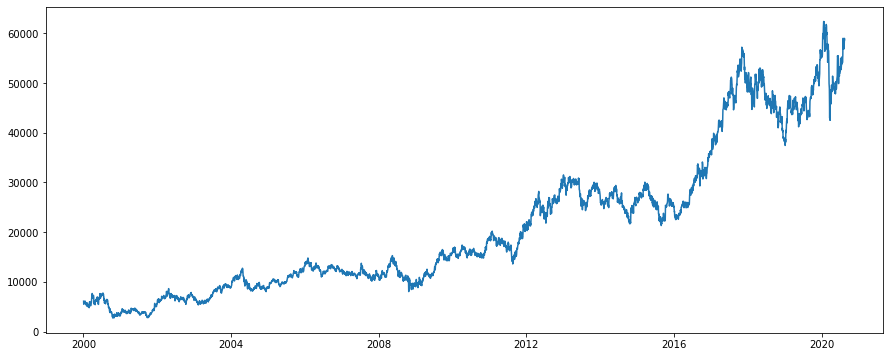

In [4]:
rcParams['figure.figsize']=15,6
plt.plot(ts)

In [5]:
# 로그 변환
ts_log=np.log(ts)

## STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [6]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [7]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

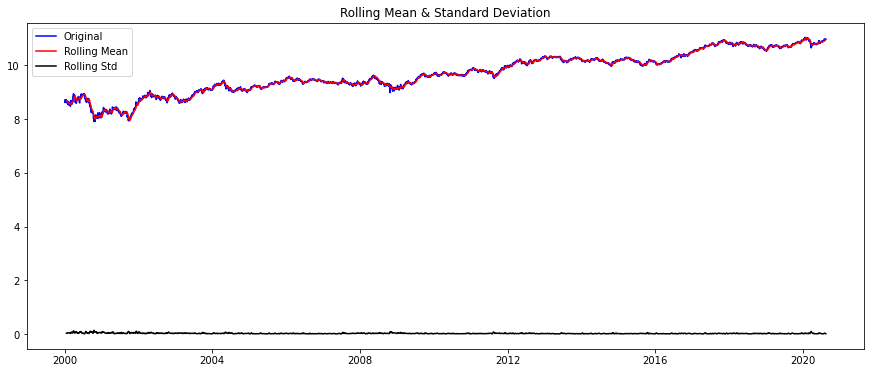

Results of Dickey-Fuller Test:
Test Statistic                   -0.687281
p-value                           0.850017
#Lags Used                        4.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


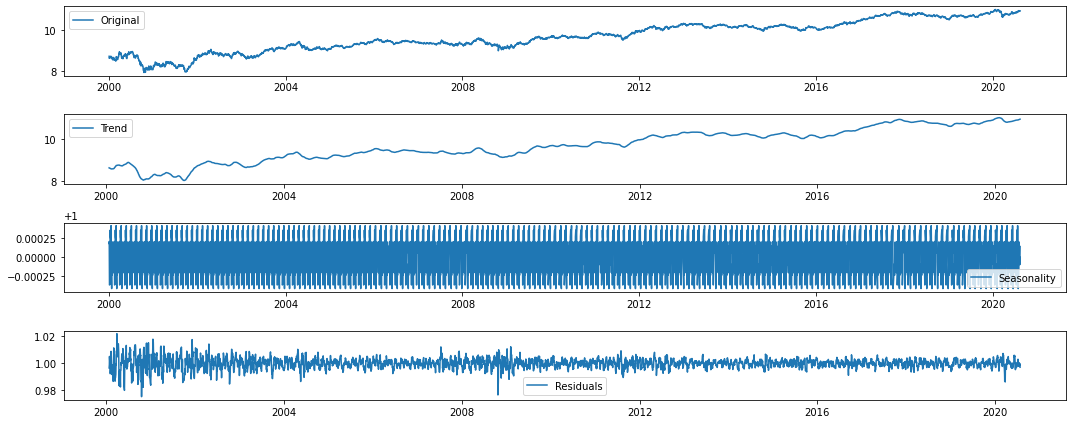

In [8]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [9]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.728531e+01
p-value                        5.748537e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.123000e+03
Critical Value (1%)           -3.431627e+00
Critical Value (5%)           -2.862104e+00
Critical Value (10%)          -2.567070e+00
dtype: float64


## Step 4 : 학습, 테스트 데이터셋 생성
---
- 학습, 테스트 데이터셋 분리

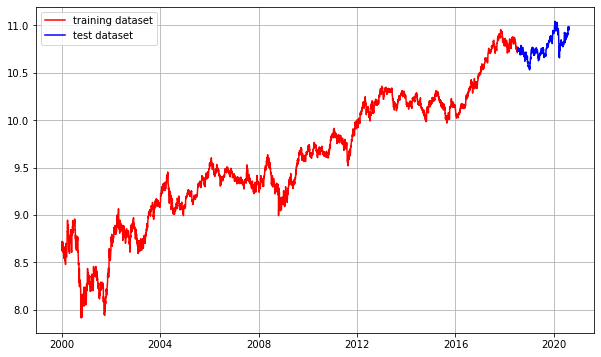

In [10]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label="training dataset")
plt.plot(test_data, c='b', label="test dataset")
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기
---
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

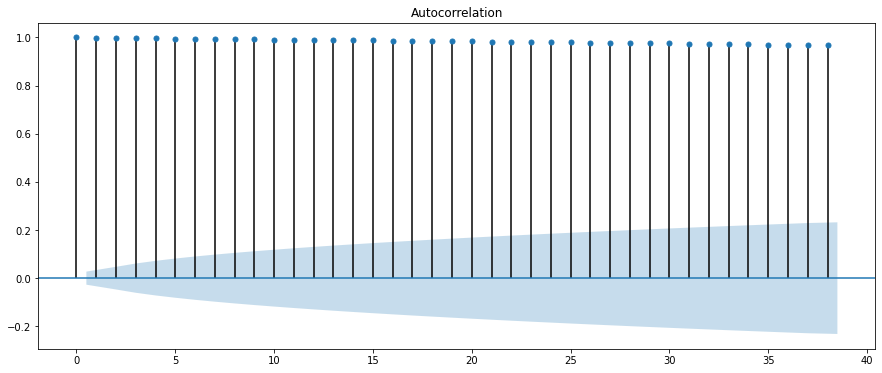

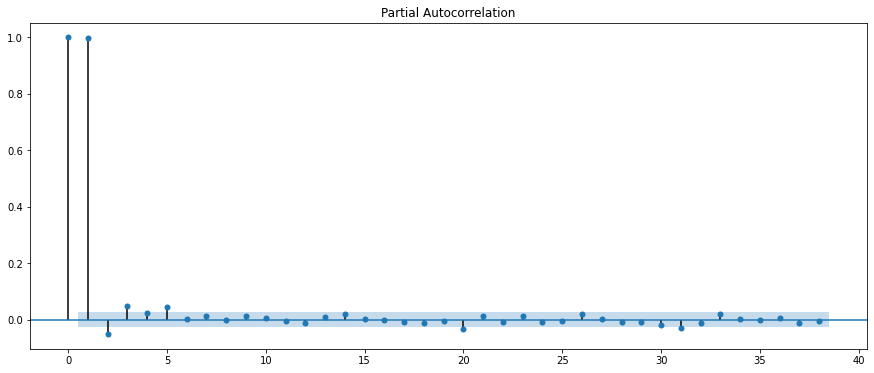

In [11]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

In [13]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]

In [14]:
diff_1.index.max

<bound method DatetimeIndexOpsMixin.max of DatetimeIndex(['2000-01-05', '2000-01-06', '2000-01-07', '2000-01-10',
               '2000-01-11', '2000-01-12', '2000-01-13', '2000-01-14',
               '2000-01-17', '2000-01-18',
               ...
               '2020-07-31', '2020-08-03', '2020-08-04', '2020-08-05',
               '2020-08-06', '2020-08-07', '2020-08-10', '2020-08-11',
               '2020-08-12', '2020-08-13'],
              dtype='datetime64[ns]', name='Date', length=5186, freq=None)>

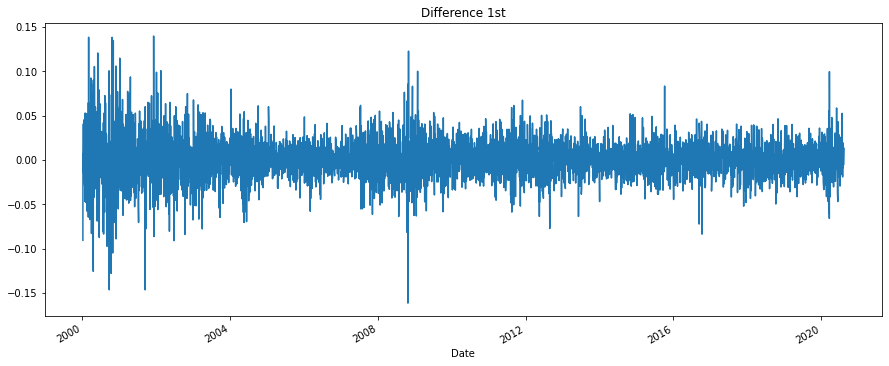

In [15]:
diff_1.plot(title="Difference 1st")

In [16]:
augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                  -39.817874
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


## STEP 6 : ARIMA 모델 훈련과 테스트
---
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)


In [17]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4667
Model:                 ARIMA(1, 1, 0)   Log Likelihood               10983.285
Method:                       css-mle   S.D. of innovations              0.023
Date:                Sun, 16 Aug 2020   AIC                         -21960.569
Time:                        12:09:26   BIC                         -21941.224
Sample:                             1   HQIC                        -21953.765
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.205      0.228      -0.000       0.001
ar.L1.D.Close     0.0478      0.015      3.262      0.001       0.019       0.076
                                    Root

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


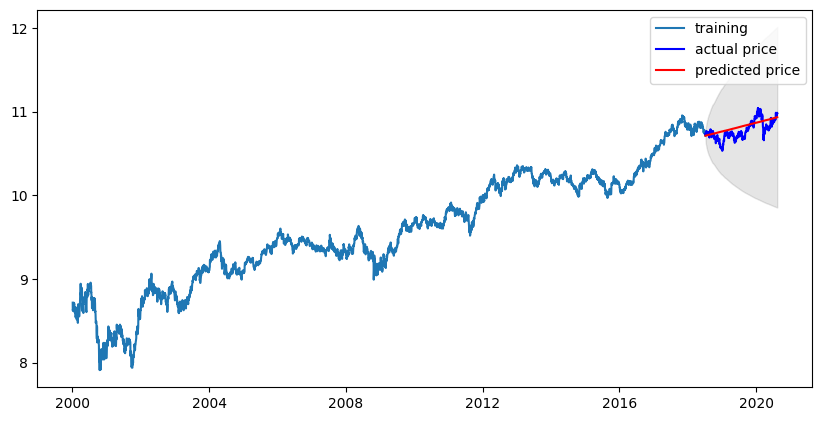

In [18]:
# Forecast
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [19]:
# final forecasting model accuracy check
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  18517858.63179965
MAE:  3590.190001880987
RMSE:  4303.238156528134
MAPE: 7.68%


# Facebook, Google, AT&T 예측
## (1) Facebook
- 최종 MAPE: 8.65%

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [45]:
dataset_filepath = os.getenv('HOME')+'/aiffel/e/e06_stock_prediction/data/FB.csv' 
df = pd.read_csv(dataset_filepath, index_col="Date", parse_dates=True) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200


In [46]:
# 2 column dataframe으로 변환
fb = df['Close']
print(type(fb.head()))
print(fb)

<class 'pandas.core.series.Series'>
Date
2012-05-18     38.230000
2012-05-21     34.029999
2012-05-22     31.000000
2012-05-23     32.000000
2012-05-24     33.029999
                 ...    
2020-08-10    263.000000
2020-08-11    256.130005
2020-08-12    259.890015
2020-08-13    261.299988
2020-08-14    261.239990
Name: Close, Length: 2074, dtype: float64


In [47]:
# 전처리 - 결측치, 로그 변환

# 결측치 처리 전
print("Before NaN interpolation\n\n", fb[fb.isna()])

# 결측치 처리
fb=fb.interpolate(method='time')
print("\nAfter interpolation\n\n", fb[fb.isna()])  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

# log transformation
fb_log=np.log(fb)

Before NaN interpolation

 Series([], Name: Close, dtype: float64)

After interpolation

 Series([], Name: Close, dtype: float64)


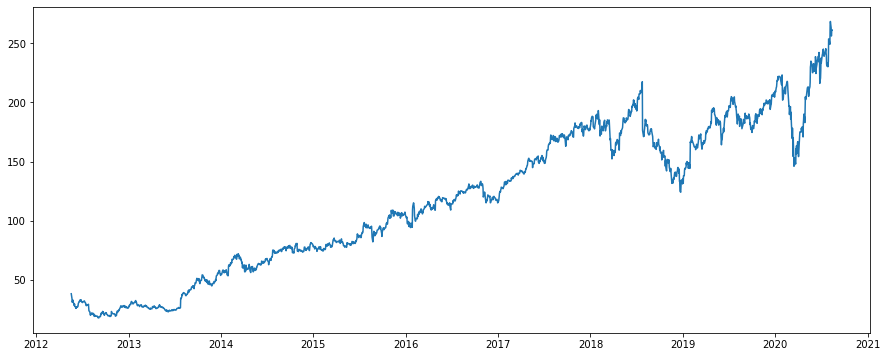

In [48]:
rcParams['figure.figsize']=15,6
plt.plot(fb)

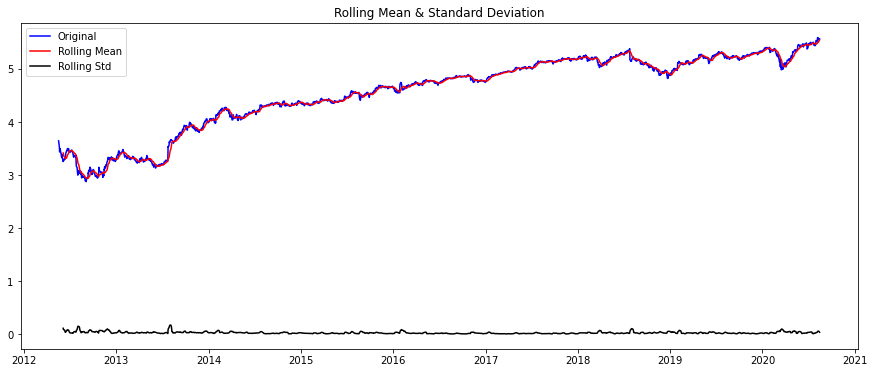

Results of Dickey-Fuller Test:
Test Statistic                   -1.174992
p-value                           0.684260
#Lags Used                       10.000000
Number of Observations Used    2063.000000
Critical Value (1%)              -3.433524
Critical Value (5%)              -2.862942
Critical Value (10%)             -2.567516
dtype: float64


In [49]:
# 시계열 안정성 분석

# 정성적 그래프 분석
plot_rolling_statistics(fb_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(fb_log)

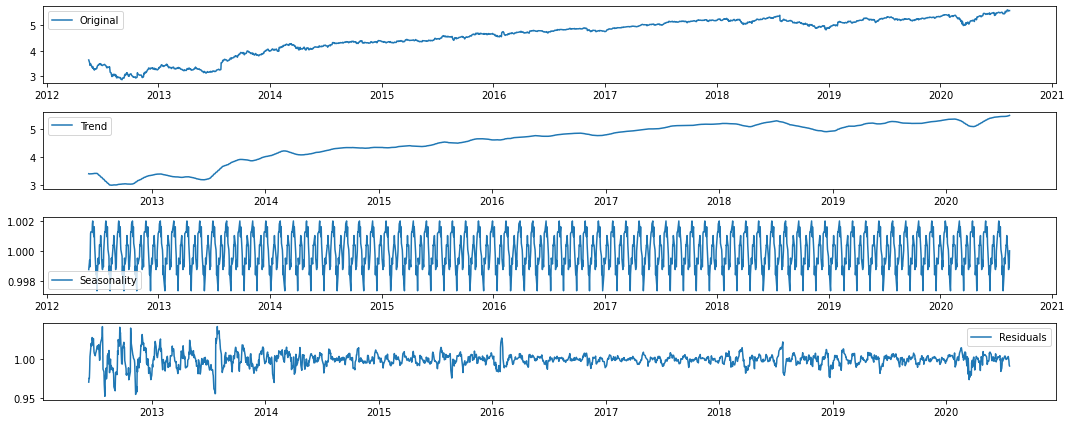

In [50]:
# 시계열 분해
decomposition = seasonal_decompose(fb_log, model='multiplicative', period = 30) 


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(fb_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [51]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.183322e+01
p-value                        7.900729e-22
#Lags Used                     2.600000e+01
Number of Observations Used    2.017000e+03
Critical Value (1%)           -3.433596e+00
Critical Value (5%)           -2.862974e+00
Critical Value (10%)          -2.567533e+00
dtype: float64


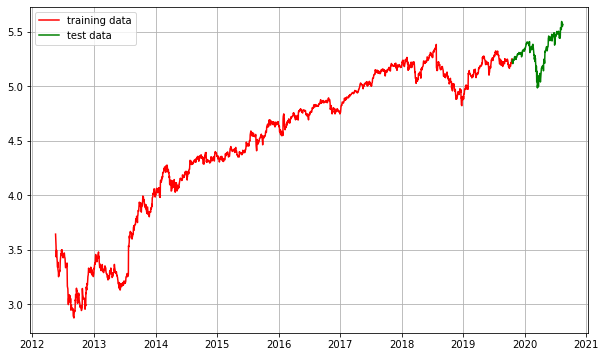

In [111]:
# train, test dataset 생성
train_data, test_data = fb_log[:int(len(fb_log)*0.9)], fb_log[int(len(fb_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label="training data")
plt.plot(test_data, c='g', label="test data")
plt.legend()

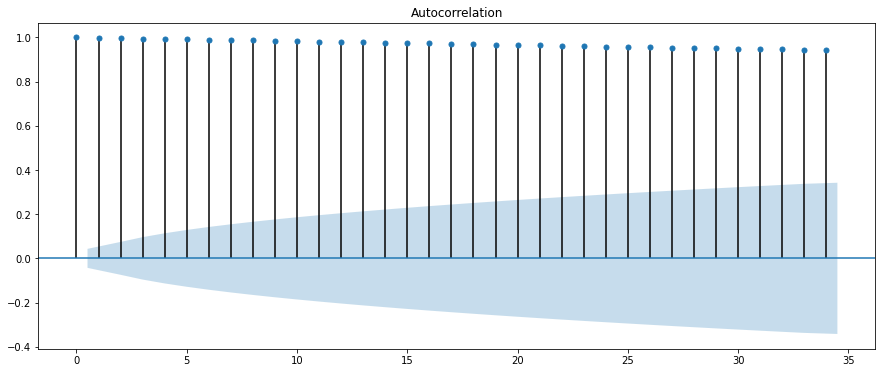

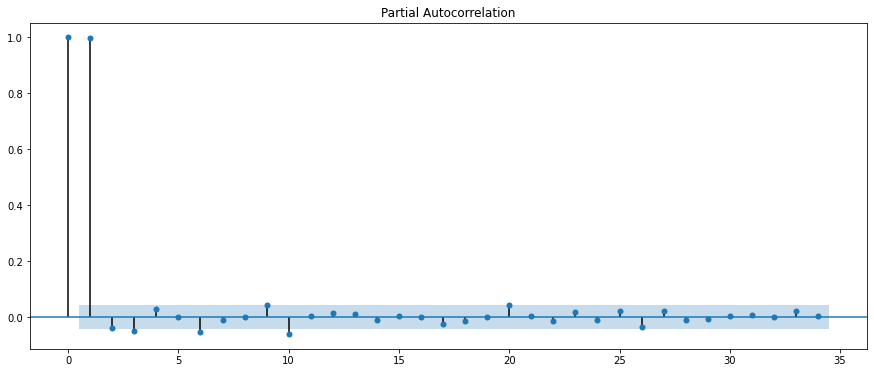

In [112]:
# arima 모수 찾기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(fb_log)
plot_pacf(fb_log)
plt.show()

In [113]:
# 차분 안정성을 확인해 d를 구한다
diff_1 = fb_log.diff(periods=1).iloc[1:]
# diff_1.index = pd.DatetimeIndex(diff_1.index).to_period('D')
diff_1.index.max

<bound method DatetimeIndexOpsMixin.max of DatetimeIndex(['2012-05-21', '2012-05-22', '2012-05-23', '2012-05-24',
               '2012-05-25', '2012-05-29', '2012-05-30', '2012-05-31',
               '2012-06-01', '2012-06-04',
               ...
               '2020-08-03', '2020-08-04', '2020-08-05', '2020-08-06',
               '2020-08-07', '2020-08-10', '2020-08-11', '2020-08-12',
               '2020-08-13', '2020-08-14'],
              dtype='datetime64[ns]', name='Date', length=2073, freq=None)>

Results of Dickey-Fuller Test:
Test Statistic                -1.441535e+01
p-value                        8.076419e-27
#Lags Used                     1.000000e+01
Number of Observations Used    2.062000e+03
Critical Value (1%)           -3.433525e+00
Critical Value (5%)           -2.862943e+00
Critical Value (10%)          -2.567517e+00
dtype: float64


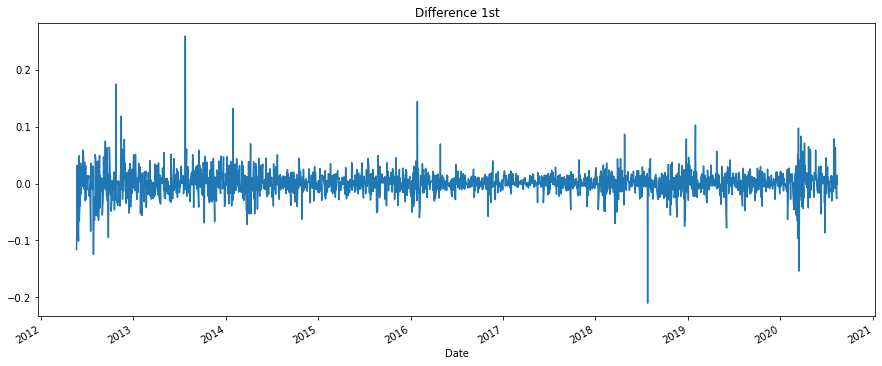

In [114]:
diff_1.plot(title="Difference 1st")

augmented_dickey_fuller_test(diff_1)

In [127]:
#  모델 훈련 및 테스트
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(0, 1, 8))
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1865
Model:                 ARIMA(0, 1, 8)   Log Likelihood                4411.817
Method:                       css-mle   S.D. of innovations              0.023
Date:                Sun, 16 Aug 2020   AIC                          -8803.634
Time:                        12:24:55   BIC                          -8748.324
Sample:                             1   HQIC                         -8783.254
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0009      0.001      1.667      0.096      -0.000       0.002
ma.L1.D.Close     0.0133      0.023      0.571      0.568      -0.032       0.059
ma.L2.D.Close    -0.0045      0.023     

In [128]:
# forcasting
fc, se, conf= fitted_m.forecast(len(test_data), alpha=0.05)

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

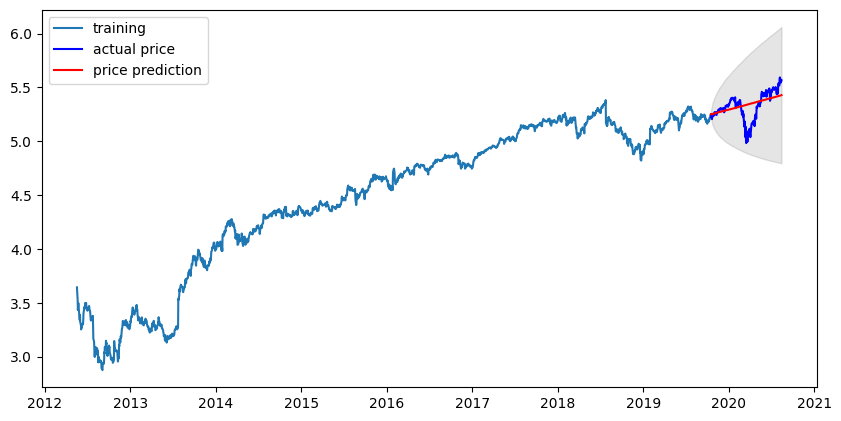

In [129]:
# plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label="training")
plt.plot(test_data, c='b', label="actual price")
plt.plot(fc_series, c='r', label="price prediction")
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [130]:
# 최종 정확도 및 MAPE 확인
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print("MSE:", mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print("MAE:", mae)

rmse = mean_squared_error(np.exp(test_data), np.exp(fc), squared=False)
print("RMSE:", rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE: 498.7907538885519
MAE: 16.66733431573207
RMSE: 22.333623841386597
MAPE: 8.65%


## (2) Google
- 최종 MAPE: dd

## (3) Naver
- 최종 MAPE: dd